--- Step 1: Loading and Preprocessing Data ---
Original Dataset Shape: (121575, 24)
Columns with all missing values: []
--- Step 2: Handling Missing Values ---
Imputing missing values in column 'Date' with mode value: '2013-03-02'
Imputing missing values in column 'Location' with mode value: 'Canberra'
Imputing missing values in column 'WindGustDir' with mode value: 'W'
Imputing missing values in column 'WindDir9am' with mode value: 'N'
Imputing missing values in column 'WindDir3pm' with mode value: 'W'
Label encoding categorical columns...
Running MICE imputation on numerical features...
Shape after imputation: (121575, 22)
   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0     20.4     25.8       0.0          6.0      12.4          6.0   
1     20.9     26.7       0.2          8.0      10.3          3.0   
2     22.3     26.3       0.0          3.2       2.0          0.0   
3     21.6     22.2       1.2          2.8       0.0          2.0   
4     20.4     23.5   

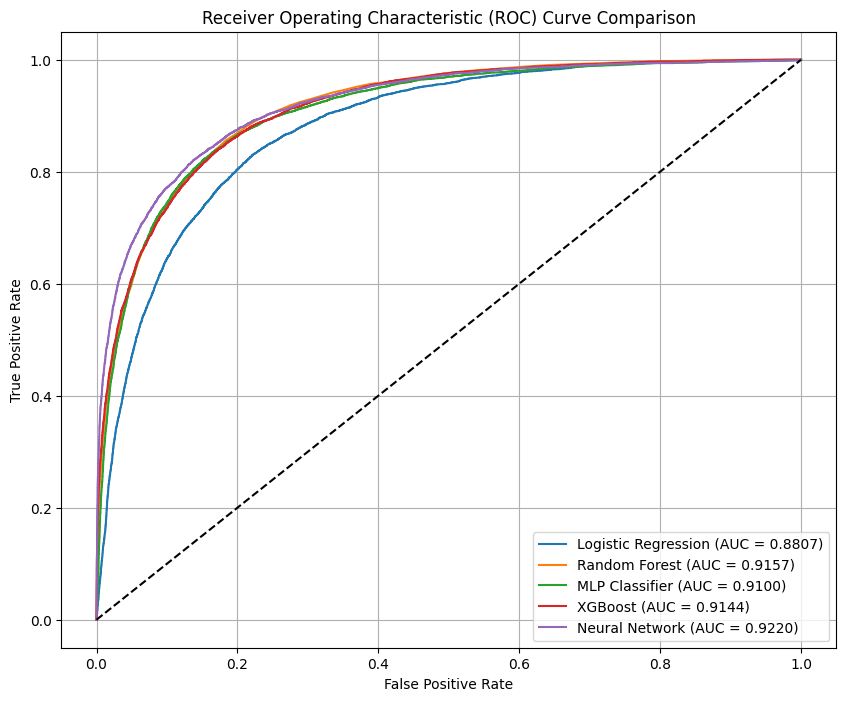


--- Final Conclusion ---
Based on ROC AUC and F1-Score for the minority class, the best performing model is likely: Neural Network


In [ ]:
# The Python script for a rainfall prediction model with detailed comments.
# This code is a complete machine learning pipeline, covering everything from data loading and cleaning
# to model training and evaluation.

# --- Step 0: Library Imports ---
# Import necessary libraries for data manipulation, visualization, preprocessing, and modeling.
import pandas as pd  # Used for data manipulation and analysis, primarily for DataFrames.
import seaborn as sns  # A high-level library for drawing attractive statistical graphics.
import matplotlib.pyplot as plt  # A comprehensive library for creating static, animated, and interactive visualizations in Python.
import numpy as np  # Needed for numerical operations and array handling.
from sklearn.preprocessing import LabelEncoder, StandardScaler  # `LabelEncoder` converts categorical text labels into numerical format, while `StandardScaler` standardizes features by removing the mean and scaling to unit variance.
from sklearn.experimental import enable_iterative_imputer  # This is needed to enable the experimental `IterativeImputer` from scikit-learn.
from sklearn.impute import IterativeImputer  # `IterativeImputer` (MICE) is an advanced technique for imputing missing values.
from sklearn.model_selection import train_test_split  # A utility to split arrays or matrices into random train and test subsets.
from sklearn.utils import resample  # Used here to oversample the minority class to handle class imbalance.
from sklearn.linear_model import LogisticRegression  # A linear model for binary classification, serving as a good baseline.
from sklearn.ensemble import RandomForestClassifier  # An ensemble method that builds multiple decision trees.
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve  # Metrics and visualization tools to evaluate model performance.
from sklearn.neural_network import MLPClassifier  # A simple Multi-layer Perceptron (neural network).
from xgboost import XGBClassifier  # A powerful and highly efficient gradient boosting library.
import tensorflow as tf  # The core deep learning library.
from tensorflow.keras.models import Sequential  # type: ignore # A way to build a neural network layer by layer.
from tensorflow.keras.layers import Dense, Dropout, Input  # type: ignore # `Dense` is a standard fully-connected layer, `Dropout` randomly sets a fraction of input units to 0 to prevent overfitting, and `Input` is used to specify the shape of the input data.
from tensorflow.keras.regularizers import l2  # type: ignore # L2 regularization is used to penalize large weights and prevent overfitting.
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore # A callback to stop training when a monitored metric has stopped improving.

print("--- Step 1: Loading and Preprocessing Data ---")
try:
    # Attempt to load the dataset. The code will execute this block.
    dataset = pd.read_csv('Extracted-dataset.csv')
except FileNotFoundError:
    # If the file is not found, this block will be executed,
    # printing an error message and exiting the script gracefully.
    print("Error: 'Extracted-dataset.csv' not found. Please check the file path.")
    exit()

print("Original Dataset Shape:", dataset.shape)

# --- STEP 1.1: Encode binary target/label columns ---
# Convert the 'Yes'/'No' string labels in 'RainToday' and 'RainTomorrow' to 1/0 for model training.
dataset['RainToday'] = dataset['RainToday'].map({'No': 0, 'Yes': 1})
dataset['RainTomorrow'] = dataset['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Check for columns that are entirely empty.
fully_missing_cols = dataset.columns[dataset.isnull().all()]
print("Columns with all missing values:", fully_missing_cols.tolist())

# --- Step 2: Handling Missing Values ---
print("--- Step 2: Handling Missing Values ---")

# Separate columns into categorical (object) and numerical (float/int).
categorical_cols = dataset.select_dtypes(include=['object']).columns
numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
columns_to_impute = [col for col in dataset.columns if col not in ['Date', 'Location']]

# Step 2.1: Impute categorical columns with mode
# Iterate through each categorical column.
for col in categorical_cols:
    # Find the most frequent value (mode) in the column.
    mode_value = dataset[col].mode()[0]
    print(f"Imputing missing values in column '{col}' with mode value: '{mode_value}'")
    # Fill any missing values (NaN) with the calculated mode.
    dataset[col] = dataset[col].fillna(mode_value)

# Step 2.2: Label Encode categorical columns
print("Label encoding categorical columns...")
lencoders = {}  # Create an empty dictionary to store each LabelEncoder instance.
# Iterate through each categorical column again.
for col in categorical_cols:
    lencoders[col] = LabelEncoder()  # Create a new LabelEncoder for the column.
    # Fit the encoder on the data and transform the column.
    dataset[col] = lencoders[col].fit_transform(dataset[col])

# Prepare a copy of the data for MICE imputation, excluding 'Date' and 'Location' as they are not needed for this process.
dataset_for_mice = dataset[columns_to_impute].copy()

# Step 2.3: Impute numerical columns using Iterative Imputer (MICE)
print("Running MICE imputation on numerical features...")
# Initialize the MICE imputer with a max_iter and random_state for reproducibility.
mice_imputer = IterativeImputer(max_iter=50, random_state=42)
# Fit the imputer on the data and transform it. This returns a NumPy array.
dataset_imputed_array = mice_imputer.fit_transform(dataset_for_mice)
# Convert the imputed array back into a pandas DataFrame, preserving the column names.
dataset_imputed = pd.DataFrame(dataset_imputed_array, columns=dataset_for_mice.columns)

print("Shape after imputation:", dataset_imputed.shape)
print(dataset_imputed.head(6))

# --- Step 3: Exploratory Data Analysis (EDA) ---
# Step 1: Keep only numeric columns for correlation analysis.
numeric_df = dataset_imputed.select_dtypes(include=['float64', 'int64'])

# Step 2: Calculate the Pearson correlation of each numeric column with the 'RainTomorrow' target.
correlation_with_target = numeric_df.corr()['RainTomorrow'].sort_values(ascending=False)

# Step 3: Print and plot correlation values.
print("\n--- Pearson Correlation with 'RainTomorrow' ---")
print(correlation_with_target)

# Create a figure for the plot.
plt.figure(figsize=(10, 6))
# Create a bar plot using seaborn. We drop 'RainTomorrow' itself from the plot as it would have a perfect correlation of 1.
sns.barplot(
    x=correlation_with_target.drop('RainTomorrow').values,
    y=correlation_with_target.drop('RainTomorrow').index
)
plt.title("Pearson Correlation with 'RainTomorrow'")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()  # Adjusts plot parameters for a tight layout.
plt.savefig('correlation_barplot.png')  # Save the plot to a file.
plt.close()  # Close the plot to free up memory.

# --- Step 4: Preparing Data for Modeling ---
# Make a copy of the imputed dataset.
data = dataset_imputed.copy()

# Remove 'RISK_MM' to prevent data leakage.
if 'RISK_MM' in data.columns:
    data.drop('RISK_MM', axis=1, inplace=True)
    print("'RISK_MM' feature removed to prevent data leakage.")
else:
    print("'RISK_MM' already removed or not present.")

print("\nUpdated dataset shape:", data.shape)
print("\nFirst 5 rows after removing 'RISK_MM':")
print(data.head())

# Define features (X) and target (y).
X = data.drop('RainTomorrow', axis=1)  # All columns except the target.
y = data['RainTomorrow']  # The target variable.

# Split the data into training (70%) and testing (30%) sets.
# `stratify=y` ensures that the class distribution is maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Standardize the numerical features.         improve training speed and stability, and to make sure all features contribute fairly to a machine learning model 
scaler = StandardScaler()
# Fit the scaler on the training data and transform it.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# Use the *same* scaler to transform the test data. Do not fit again.
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Training Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("Testing Set Class Distribution:\n", y_test.value_counts(normalize=True))

# Plot the class distribution before oversampling.
y_train_df = pd.DataFrame(y_train)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_df['RainTomorrow'], hue=y_train_df['RainTomorrow'], palette='pastel', legend=False)
plt.title("Class Distribution Before Oversampling")
plt.xlabel("RainTomorrow (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.savefig('class_distribution_before_oversampling.png')
plt.close()

# --- Step 5: Oversampling and Handling Outliers on Training Data ---
print("\n--- Step 3: Oversampling and Handling Outliers on Training Data ---")
# Combine the scaled training features and the training labels into a single DataFrame.
df_train_combined = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
# Separate the majority (0) and minority (1) classes.
minority_class = df_train_combined[df_train_combined['RainTomorrow'] == 1]
majority_class = df_train_combined[df_train_combined['RainTomorrow'] == 0]

# Perform oversampling on the minority class.
if not minority_class.empty:
    # Resample the minority class with replacement to match the size of the majority class.
    minority_oversampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
    # Combine the resampled minority class with the original majority class.
    df_train_resampled = pd.concat([majority_class, minority_oversampled])
else:
    print("⚠️ Minority class is empty. Oversampling not performed.")
    df_train_resampled = df_train_combined.copy()

print("Class distribution after oversampling:\n", df_train_resampled['RainTomorrow'].value_counts())
# Plot the new balanced class distribution.
plt.figure(figsize=(6, 4))
sns.countplot(x=df_train_resampled['RainTomorrow'], hue=df_train_resampled['RainTomorrow'], palette='pastel', legend=False)
plt.title("Class Distribution After Oversampling", fontsize=14)
plt.xlabel("Rain Tomorrow (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'])
plt.savefig('class_distribution_after_oversampling.png')
plt.close()

# Outlier removal using the Interquartile Range (IQR) method.
features_to_clean = df_train_resampled.drop('RainTomorrow', axis=1)
Q1 = features_to_clean.quantile(0.25)
Q3 = features_to_clean.quantile(0.75)
IQR = Q3 - Q1
# Create a mask to identify rows with outliers.
outlier_mask = ((features_to_clean < (Q1 - 1.5 * IQR)) | (features_to_clean > (Q3 + 1.5 * IQR))).any(axis=1)
# Keep only the rows that are NOT outliers.
cleaned_resampled = df_train_resampled[~outlier_mask]

# Separate the final clean features and target for training.
X_train_final = cleaned_resampled.drop('RainTomorrow', axis=1)
y_train_final = cleaned_resampled['RainTomorrow']

print("Final shape after outlier removal:", cleaned_resampled.shape)
print("Final class distribution:\n", y_train_final.value_counts(normalize=True))

final_cleaned_data = pd.concat([X_train_final, y_train_final], axis=1)
print("\n--- Final Cleaned Training Dataset (Preview) ---")
print(final_cleaned_data.head())
final_cleaned_data.to_csv('Cleaned-dataset.csv', index=False)
print("\n✅ Final cleaned dataset saved as 'Cleaned-dataset.csv'")

# --- Step 6: Model Training and Evaluation ---
# Initialize the list of models to train.
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}
results = {}  # Dictionary to store performance results for each model.

# Loop through each model in the dictionary.
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    # Train the model using the final cleaned training data.
    model.fit(X_train_final, y_train_final)

    # Make predictions on the scaled test data.
    y_pred = model.predict(X_test_scaled)
    # Get probability scores for the ROC AUC calculation.
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Store the evaluation metrics.
    results[model_name] = {
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

    # Print the evaluation results.
    print(f"--- {model_name} Evaluation on Test Data ---")
    print(f"ROC AUC Score: {results[model_name]['ROC_AUC']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Generate and save a confusion matrix plot.
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.close(fig)

    # --- Add Neural Network Model ---
print("\n--- Training Neural Network ---")

# Define the Neural Network model
nn_model = Sequential([
    tf.keras.layers.Input(shape=(X_train_final.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=[tf.keras.metrics.AUC(name='auc')])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train_final, y_train_final,
                        epochs=100,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0) # Kept verbose=0 as in original code

# Evaluate the Neural Network
y_pred_proba_nn = nn_model.predict(X_test_scaled).ravel()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

results['Neural Network'] = {
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_nn),
    'Classification Report': classification_report(y_test, y_pred_nn, output_dict=True)
}

print(f"--- Neural Network Evaluation on Test Data ---")
print(f"ROC AUC Score: {results['Neural Network']['ROC_AUC']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=['No Rain', 'Rain'])
fig_nn, ax_nn = plt.subplots(figsize=(6, 6))
disp_nn.plot(cmap=plt.cm.Blues, ax=ax_nn)
disp_nn.ax_.set_title(f"Confusion Matrix for Neural Network")
plt.savefig(f'confusion_matrix_Neural_Network.png')
plt.close(fig_nn)

# --- Step 5: Final Model Comparison Summary ---
print("\n--- Step 5: Final Model Comparison Summary ---")

performance_data = []

# --- CORRECTED SECTION START ---
# Dynamically find the string representation of the positive class label (e.g., '1' or '1.0')
# This is more robust than hardcoding '1'. We get the last unique label, which is the positive class.
positive_class_label = str(np.unique(y_test)[-1])
print(f"Metrics will be extracted for the positive class: '{positive_class_label}'")

for model_name, metrics in results.items():
    report = metrics.get('Classification Report', {}) # Use .get for safety

    # Check if the dynamically found positive class label exists in the report
    if positive_class_label in report:
        precision_1 = report[positive_class_label]['precision']
        recall_1 = report[positive_class_label]['recall']
        f1_score_1 = report[positive_class_label]['f1-score']
    else:
        # This now correctly handles cases where the class report might be missing
        precision_1 = recall_1 = f1_score_1 = 0.0

    performance_data.append({
        'Model': model_name,
        'ROC_AUC': metrics.get('ROC_AUC', 0.0),
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_score_1
    })
# --- CORRECTED SECTION END ---

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.sort_values(by='ROC_AUC', ascending=False)
print(performance_df)

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Add the new NN model to the dictionary for plotting
models['Neural Network'] = nn_model

for model_name, model in models.items():
    # Use a unified prediction method for plotting
    if hasattr(model, 'predict_proba'): # For scikit-learn models
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else: # For TensorFlow/Keras models
        y_pred_proba = model.predict(X_test_scaled).ravel()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Final Conclusion
print("\n--- Final Conclusion ---")
if not performance_df.empty:
    best_model = performance_df.iloc[0]['Model']
    print(f"Based on ROC AUC and F1-Score for the minority class, the best performing model is likely: {best_model}")
else:
    print("Performance data is empty. Could not determine the best model.")
